## Introduction

This in-class example demonstrates how to calculate heteroskeasticity-robust standard error and conduct tests on the existence of heteroskedasticity.

What you need to know:  
- Statsmodels and pandas modules in python
- Theoretical concepts on linear regression model
- Theoretical concepts on heteroskedasticity

The list of [references](#References) for detailed concepts and techniques used in this exerise.
***

## Content
- [Model under the assumption of *homoskedasticity*](#Model-under-the-assumption-of-*homoskedasticity*)
- [Test for heteroskedasticity](#Test-for-heteroskedasticity)
- [Model under the assumption of *heteroskedasticity*](#Model-under-the-assumption-of-*heteroskedasticity*) 
- [References](#References)

***

## Data Description

The data set is contained in a comma-separated value (csv) file named ```hprice1.csv``` with column headers. 

Description of the data is as follow:
 
| Name | Description |
| :--- | :--- |
| price    | house price, \$1000s |
| assess   | assessed value, \$1000s |
| bdrms    | number of bdrms |
| lotsize  | size of lot in square feet |
| sqrft    | size of house in square feet |
| colonial | =1 if home is colonial style |
| lprice   | log(price) |
| lassess  | log(assess) |
| llotsize | log(lotsize) |
| lsqrft   | log(sqrft) |

***
## Load the required modules

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as smd
import matplotlib.pyplot

***
## Import the data set

#### Load the data set into Python

In [2]:
hprice = pd.read_csv("hprice1.csv")

***
## Estimate a House Price Model

Consider a house price model in terms of the levels:
$$price = \beta_0 + \beta_1 lotsize + \beta_2 sqrft + \beta_3 bdrms + u$$

### Model under the assumption of *homoskedasticity*

#### Estimate the model

In [3]:
model = smf.ols(formula = 'price ~ lotsize + sqrft + bdrms', data = hprice).fit()

#### Get the estimation results

In [5]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     57.46
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           2.70e-20
Time:                        15:00:35   Log-Likelihood:                -482.88
No. Observations:                  88   AIC:                             973.8
Df Residuals:                      84   BIC:                             983.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.7703     29.475     -0.739      0.4

***
### Test for heteroskedasticity

There are a few useful Python [methods](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html) for linear regression results in the Statsmodels module that we use here:
- ```resid``` for the residuals of the estimated model
- ```model.exog``` for the data of the exogenous regressors

Label the test statistics. Later we will use the ```zip()``` function to return combine the label with the test statistics.

In [6]:
labels = ['LM Statistics', 'LM-Test p-value', 'F-Statistics', 'F-Test p-value']

#### Breusch-Pagan test

Estimate the equation
$$\hat{u}^2 = \delta_0 + \delta_1 x_1 + \ldots + \delta_k x_k + error$$

Null hypothesis: 
$$H_0: \delta_1 = \delta_2 = \ldots = \delta_k = 0$$

In [ ]:
bp_test = smd.het_breuschpagan(model.resid, model.model.exog)
dict(zip(labels, bp_test))

(np.float64(14.09238551459098), np.float64(0.0027820595423350978), np.float64(5.338919367860907), np.float64(0.002047744409670769))


{'LM Statistics': np.float64(14.09238551459098),
 'LM-Test p-value': np.float64(0.0027820595423350978),
 'F-Statistics': np.float64(5.338919367860907),
 'F-Test p-value': np.float64(0.002047744409670769)}

#### White test

For a model contains $k=3$ independent variables:
$$\hat{u}^2 = \delta_0 + \delta_1 x_1 + \delta_2 x_2 + \delta_3 x_3 + \delta_4 x_1^2 + \delta_5 x_2^2 + \delta_6 x_3^2 + \delta_7 x_1 x_2 + \delta_8 x_1 x_3 + \delta_9 x_2 x_3 + error$$

Null hypothesis:
$$H_0: \delta_1 = \delta_2 = \ldots = \delta_9 = 0$$

In [13]:
white_test = smd.het_white(model.resid, model.model.exog)
dict(zip(labels, white_test))

{'LM Statistics': np.float64(33.73165748164103),
 'LM-Test p-value': np.float64(9.952940693798682e-05),
 'F-Statistics': np.float64(5.386953386473093),
 'F-Test p-value': np.float64(1.0129389769589199e-05)}

#### White test (specific form)

Use $\hat{y}_i^2$ to get a particular function of all the squares and cross products
$$\hat{u}^2 = \delta_0 + \delta_1 \hat{y} + \delta_2 \hat{y}^2 + error$$

Null hypothesis: $$H_0: \delta_1 = 0, \delta_2 = 0$$

Create the set of regressors

In [17]:
cons_term = np.ones(len(model.predict()))
white_regressors = np.column_stack([model.predict(), model.predict()**2.0, cons_term])

Conduct the test:

In [19]:
white_test_special = smd.het_white(model.resid, white_regressors)
dict(zip(labels, white_test_special))

{'LM Statistics': np.float64(17.584498728567),
 'LM-Test p-value': np.float64(0.0014875003686478062),
 'F-Statistics': np.float64(5.181790117651173),
 'F-Test p-value': np.float64(0.0008919571003527716)}

***
### Create a scatter plot to visualize the heteroskedastic variance

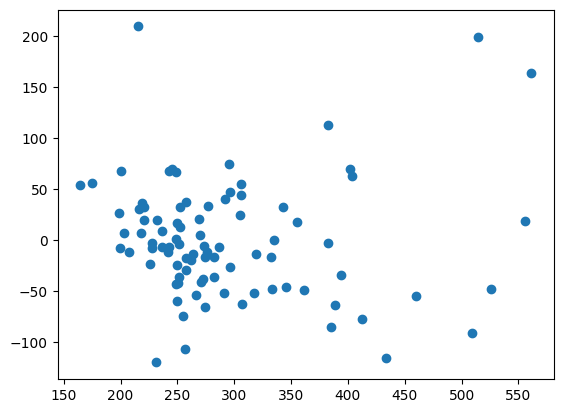

In [20]:
matplotlib.pyplot.scatter(model.predict(), model.resid)

***
## Model under the assumption of *heteroskedasticity*

#### Estimate the model
For robust standard error in MacKinnon and White (1985), specify the covariance type using ```cov_type='HC1'``` in OLS class method ```fit()```.

In [22]:
model_robust = smf.ols(formula = 'price ~ lotsize + sqrft + bdrms', data = hprice).fit(cov_type='HC1')

#### Get the estimation results

In [23]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     57.46
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           2.70e-20
Time:                        16:00:12   Log-Likelihood:                -482.88
No. Observations:                  88   AIC:                             973.8
Df Residuals:                      84   BIC:                             983.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.7703     29.475     -0.739      0.4

***

## References

- Jeffrey M. Wooldridge (2019). "Introductory Econometrics: A Modern Approach, 7e" Chapter 8.
    
- The pandas development team (2020). "[pandas-dev/pandas: Pandas](https://pandas.pydata.org/)." Zenodo.
    
- Seabold, Skipper, and Josef Perktold (2010). "[statsmodels: Econometric and statistical modeling with python](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)." Proceedings of the 9th Python in Science Conference.